In [ ]:
import re
import nltk
import torch
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
nltk.download('stopwords')
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import defaultdict
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertTokenizer, DistilBertForSequenceClassification, XLMRobertaTokenizer, XLMRobertaForSequenceClassification, get_linear_schedule_with_warmup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Replace the path with the correct file path
ds = pd.read_csv('/content/gdrive/MyDrive/Hindi_mbti_utf8.csv')
ds

,type,posts,Unnamed: 2
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw|||h...,http://www.youtube.com/watch?v=qsXHcwe3krw|||h...
1,ENTP,I'm finding the lack of me in these posts very...,मुझे इन पोस्टों में अपनी कमी बहुत चिंताजनक लग ...
2,INTP,Good one _____ https://www.youtube.com/watc...,अच्छा है _____ https://www.youtube.com/watch?v...
3,INTJ,"Dear INTP, I enjoyed our conversation the ot...","प्रिय आईएनटीपी, मैंने दूसरे दिन हमारी बातचीत क..."
4,ENTJ,You're fired.|||That's another silly misconcep...,आपको निकाल दिया गया है।|||यह एक और मूर्खतापूर्...
...,...,...,...
8672,INTP,So many questions when i do these things. I wo...,जब मैं ये चीजें करता हूं तो बहुत सारे प्रश्न ह...
8673,INFP,I am very conflicted right now when it comes t...,जब बच्चे चाहने की बात आती है तो मैं इस समय बहु...
8674,INFP,It has been too long since I have been on pers...,मुझे पर्सनेलिटी कैफे में रहते हुए बहुत समय हो ...
8675,NaN,NaN,NaN


In [ ]:
ds = ds.rename(columns={'Unnamed: 2': 'Hindi_posts'})
ds = ds.drop(columns=['posts'])
ds

,type,Hindi_posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw|||h...
1,ENTP,मुझे इन पोस्टों में अपनी कमी बहुत चिंताजनक लग ...
2,INTP,अच्छा है _____ https://www.youtube.com/watch?v...
3,INTJ,"प्रिय आईएनटीपी, मैंने दूसरे दिन हमारी बातचीत क..."
4,ENTJ,आपको निकाल दिया गया है।|||यह एक और मूर्खतापूर्...
...,...,...
8672,INTP,जब मैं ये चीजें करता हूं तो बहुत सारे प्रश्न ह...
8673,INFP,जब बच्चे चाहने की बात आती है तो मैं इस समय बहु...
8674,INFP,मुझे पर्सनेलिटी कैफे में रहते हुए बहुत समय हो ...
8675,NaN,NaN


<Axes: xlabel='type'>

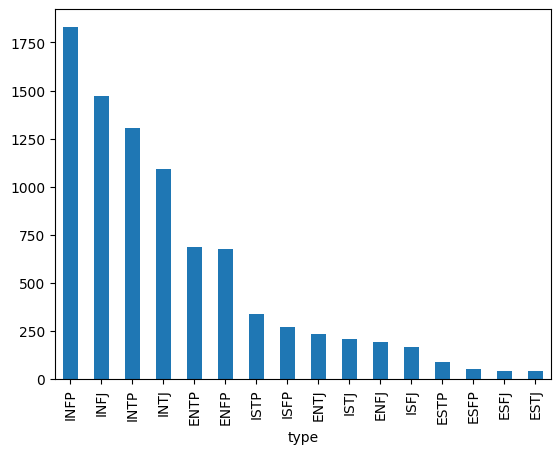

In [ ]:
ds["type"].value_counts().plot(kind = "bar")

Plotting top stopwords chart

In [ ]:
# Define stopwords in Hindi
stop = [
    "अंदर", "अत", "अदि", "अप", "अपना", "अपनि", "अपनी", "अपने", "अभि", "अभी", "आदि", "आप", "इतयादि",
    "इत्यादि", "इन", "इनका", "इन्हीं", "इन्हें", "इन्हों", "इस", "इसका", "इसकि", "इसकी", "इसके",
    "इसमें", "इसि", "इसी", "इसे", "उन", "उनका", "उनकि", "उनकी", "उनके", "उनको", "उन्हीं", "उन्हें",
    "उन्हों", "उस", "उसके", "उसि", "उसी", "उसे", "एक", "एवं", "एस", "एसे", "ऐसे", "ओर", "और", "कइ",
    "कई", "कर", "करता", "करते", "करना", "करने", "कर…", "बहुत", "बाद", "बाला", "बिलकुल", "भि",
    "भितर", "भी", "भीतर", "मगर", "मानो", "मे", "में", "यदि", "यह", "यहाँ", "यहां", "यहि", "यही",
    "या", "यिह", "ये", "रखें", "रवासा", "रहा", "रहे", "ऱ्वासा", "लिए", "लिये", "लेकिन", "व", "वगेरह",
    "वरग", "वर्ग", "वह", "वहाँ", "वहां", "वहिं", "वहीं", "वाले", "वुह", "वे", "वग़ैरह", "संग", "सकता",
    "सकते", "सबसे", "सभि", "सभी", "साथ", "साबुत", "साभ", "सारा", "से", "सो", "संग", "ही", "हुआ", "हुई",
    "हुए", "है", "हो", "होता", "होति", "होती", "होते"
]

# Ensure 'Hindi_posts' column is of string type
ds['Hindi_posts'] = ds['Hindi_posts'].astype(str)

# Define a function to clean posts
def clean_post(post):
    post = re.sub(r"https?:\/\/(www)?.?([A-Za-z_0-9-]+)([\S])*", "", post)  # Remove links
    post = re.sub("\|\|\|", "", post)  # Remove |||
    post = re.sub("[0-9]", "", post)  # Remove numbers
    # Add more cleaning steps as needed
    return post

# Apply the cleaning function to each post in the 'Hindi_posts' column
ds['Hindi_posts'] = ds['Hindi_posts'].apply(clean_post)

# Initialize Porter Stemmer
ps = PorterStemmer()

# Define a function for stemming
def stemming(row):
    return " ".join([ps.stem(word) for word in row.split() if word not in stop])

# Apply stemming to the 'Hindi_posts' column and create a new column 'clean_posts'
ds["clean_posts"] = ds["Hindi_posts"].apply(stemming)
ds["clean_posts"].head()

0    intj क्षण watch?v=izlegxm स्पोर्ट्ससेंटर शीर्ष...
1    मुझे पोस्टों कमी चिंताजनक लग रही है।सेक्स अगर ...
2    अच्छा _____ मैं कहता हूं कि मुझे पता है; मेरा ...
3    प्रिय आईएनटीपी, मैंने दूसरे दिन हमारी बातचीत क...
4    आपको निकाल दिया गया है।यह मूर्खतापूर्ण ग़लतफ़ह...
Name: clean_posts, dtype: object

In [ ]:
ds

,type,Hindi_posts,clean_posts
0,INFJ,और intj क्षण watch?v=izlEgXM स्पोर्ट्ससेंटर ...,intj क्षण watch?v=izlegxm स्पोर्ट्ससेंटर शीर्ष...
1,ENTP,मुझे इन पोस्टों में अपनी कमी बहुत चिंताजनक लग ...,मुझे पोस्टों कमी चिंताजनक लग रही है।सेक्स अगर ...
2,INTP,अच्छा है _____ मैं कहता हूं कि मुझे पता है; य...,अच्छा _____ मैं कहता हूं कि मुझे पता है; मेरा ...
3,INTJ,"प्रिय आईएनटीपी, मैंने दूसरे दिन हमारी बातचीत क...","प्रिय आईएनटीपी, मैंने दूसरे दिन हमारी बातचीत क..."
4,ENTJ,आपको निकाल दिया गया है।यह एक और मूर्खतापूर्ण ग...,आपको निकाल दिया गया है।यह मूर्खतापूर्ण ग़लतफ़ह...
...,...,...,...
8672,INTP,जब मैं ये चीजें करता हूं तो बहुत सारे प्रश्न ह...,जब मैं चीजें हूं तो सारे प्रश्न हैं। मैं बैंगन...
8673,INFP,जब बच्चे चाहने की बात आती है तो मैं इस समय बहु...,जब बच्चे चाहने की बात आती तो मैं समय उलझन हूँ।...
8674,INFP,मुझे पर्सनेलिटी कैफे में रहते हुए बहुत समय हो ...,मुझे पर्सनेलिटी कैफे रहते समय गया - हालाँकि ज़...
8675,NaN,nan,nan


In [ ]:
ds = ds.drop(columns='Hindi_posts')
ds=ds.dropna()
ds

,type,clean_posts
0,INFJ,intj क्षण watch?v=izlegxm स्पोर्ट्ससेंटर शीर्ष...
1,ENTP,मुझे पोस्टों कमी चिंताजनक लग रही है।सेक्स अगर ...
2,INTP,अच्छा _____ मैं कहता हूं कि मुझे पता है; मेरा ...
3,INTJ,"प्रिय आईएनटीपी, मैंने दूसरे दिन हमारी बातचीत क..."
4,ENTJ,आपको निकाल दिया गया है।यह मूर्खतापूर्ण ग़लतफ़ह...
...,...,...
8670,ISFP,सिर्फ इसलिए कि मैं हमेशा किसी कारण बिल्लियों क...
8671,ENFP,तो...यदि थ्रेड पहले कहीं मौजूद (जो है: तो मैं ...
8672,INTP,जब मैं चीजें हूं तो सारे प्रश्न हैं। मैं बैंगन...
8673,INFP,जब बच्चे चाहने की बात आती तो मैं समय उलझन हूँ।...


# Define Models and Tokenizer

In [ ]:
# Tokenizers
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
distilbert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

# Models
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=16,  # Number of unique labels
    output_attentions=False,
    output_hidden_states=False
)

xlmr_model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=16,
    output_attentions=False,
    output_hidden_states=False
)

models = {
    "mBERT": (bert_model, bert_tokenizer),
    "XLM-R": (xlmr_model, xlmr_tokenizer),
    "DistilBERT": (distilbert_model, distilbert_tokenizer)
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Define Some Functions

In [ ]:
# Function to preprocess text for BERT
def preprocess_text_bert(text, tokenizer, max_len=128):
    tokenized_text = bert_tokenizer.tokenize(text)
    tokenized_text = ["[CLS]"] + tokenized_text + ["[SEP]"]
    input_ids = tokenizer.convert_tokens_to_ids(tokenized_text)
    input_ids = input_ids[:max_len] + [tokenizer.pad_token_id] * (max_len - len(input_ids))
    attention_mask = [1] * len(input_ids)
    return torch.tensor(input_ids), torch.tensor(attention_mask)

# Function to preprocess text for DistilBERT
def preprocess_text_distilbert(text, tokenizer, max_len=128):
    inputs = distilbert_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask

def preprocess_text_xlmr(text, tokenizer, max_len=128):
    inputs = xlmr_tokenizer(
       text,
       padding='max_length',
       truncation=True,
       max_length=max_len,
       return_tensors='pt'
    )
    return inputs.input_ids, inputs.attention_mask


In [ ]:
# Function to train and evaluate a model
def train_and_evaluate(model, train_dataloader, test_dataloader, optimizer, scheduler, device, epochs=3):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            model.zero_grad()
            outputs = model(inputs, attention_mask=masks, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

        avg_train_loss = total_loss / len(train_dataloader)
        print(f"Average Training Loss for {model.__class__.__name__}: {avg_train_loss}")

    model.eval()
    preds = []
    true_labels = []
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        batch = tuple(t.to(device) for t in batch)
        inputs, masks, labels = batch
        with torch.no_grad():
            outputs = model(inputs, attention_mask=masks)
            logits = outputs.logits
        preds.append(logits.detach().cpu().numpy())
        true_labels.append(labels.cpu().numpy())

    preds = np.concatenate(preds, axis=0)
    true_labels = np.concatenate(true_labels, axis=0)
    return preds, true_labels

In [ ]:
def plot_confusion_matrix(conf_matrix, label_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

def calculate_metrics(true_labels, predicted_labels):
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    class_report = classification_report(true_labels, predicted_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    return conf_matrix, class_report, accuracy, f1, precision, recall


In [ ]:
# Function to plot ROC curve and calculate AUC
def plot_roc_curve(true_labels, predicted_probs, label_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(label_names)):
        fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], predicted_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(true_labels.ravel(), predicted_probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', lw=2, label='Micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Define Model Dictionary

In [ ]:
# Define labels dictionary
labels_dict = {
    'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
    'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
    'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
    'ESTJ': 14, 'ESFJ': 15
}

# Model Fine Tuning

In [ ]:
# Define batch size and other parameters
batch_size = 32
max_len = 128
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
input_ids_list = []
attention_mask_list = []

input_ids_list_xlmr = []
attention_mask_list_xlmr = []

input_ids_list_distilbert = []
attention_mask_list_distilbert = []

labels = [labels_dict[label] for label in ds['type'][:8000]]
labels = torch.tensor(labels)

for text in ds['clean_posts'][:8000]:
    # For mBERT
    input_ids, attention_mask = preprocess_text_bert(text, models['mBERT'][1], max_len)
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

    # For XLM-R
    input_ids_xlmr, attention_mask_xlmr = preprocess_text_xlmr(text, models['XLM-R'][1], max_len)
    input_ids_list_xlmr.append(input_ids_xlmr)
    attention_mask_list_xlmr.append(attention_mask_xlmr)

    # For DistilBERT
    input_ids_distilbert, attention_mask_distilbert = preprocess_text_distilbert(text, models['DistilBERT'][1], max_len)
    input_ids_list_distilbert.append(input_ids_distilbert)
    attention_mask_list_distilbert.append(attention_mask_distilbert)


input_ids_tensor_bert = torch.stack(input_ids_list)
attention_mask_tensor_bert = torch.stack(attention_mask_list)

input_ids_tensor_xlmr = torch.stack(input_ids_list_xlmr)
attention_mask_tensor_xlmr = torch.stack(attention_mask_list_xlmr)

input_ids_tensor_distilbert = torch.stack(input_ids_list_distilbert)
attention_mask_tensor_distilbert = torch.stack(attention_mask_list_distilbert)


In [ ]:
# For BERT

train_inputs_bert, test_inputs_bert, train_masks_bert, test_masks_bert, train_labels_bert, test_labels_bert = train_test_split(
    input_ids_tensor_bert, attention_mask_tensor_bert, labels, test_size=0.3, random_state=42
)

train_data_bert = TensorDataset(train_inputs_bert, train_masks_bert, train_labels_bert)
train_sampler_bert = RandomSampler(train_data_bert)
train_dataloader_bert = DataLoader(train_data_bert, sampler=train_sampler_bert, batch_size=batch_size)

test_data_bert = TensorDataset(test_inputs_bert, test_masks_bert, test_labels_bert)
test_sampler_bert = SequentialSampler(test_data_bert)
test_dataloader_bert = DataLoader(test_data_bert, sampler=test_sampler_bert, batch_size=batch_size)



# For XLM-R
train_inputs_xlmr, test_inputs_xlmr, train_masks_xlmr, test_masks_xlmr, train_labels_xlmr, test_labels_xlmr = train_test_split(
    input_ids_tensor_xlmr, attention_mask_tensor_xlmr, labels, test_size=0.3, random_state=42
)

train_data_xlmr = TensorDataset(train_inputs_xlmr, train_masks_xlmr, train_labels_xlmr)
train_sampler_xlmr = RandomSampler(train_data_xlmr)
train_dataloader_xlmr = DataLoader(train_data_xlmr, sampler=train_sampler_xlmr, batch_size=batch_size)

test_data_xlmr = TensorDataset(test_inputs_xlmr, test_masks_xlmr, test_labels_xlmr)
test_sampler_xlmr = SequentialSampler(test_data_xlmr)
test_dataloader_xlmr = DataLoader(test_data_xlmr, sampler=test_sampler_xlmr, batch_size=batch_size)

# For DistilBERT
train_inputs_distilbert, test_inputs_distilbert, train_masks_distilbert, test_masks_distilbert, train_labels_distilbert, test_labels_distilbert = train_test_split(
    input_ids_tensor_distilbert, attention_mask_tensor_distilbert, labels, test_size=0.3, random_state=42
)

train_data_distilbert = TensorDataset(train_inputs_distilbert, train_masks_distilbert, train_labels_distilbert)
train_sampler_distilbert = RandomSampler(train_data_distilbert)
train_dataloader_distilbert = DataLoader(train_data_distilbert, sampler=train_sampler_distilbert, batch_size=batch_size)

test_data_distilbert = TensorDataset(test_inputs_distilbert, test_masks_distilbert, test_labels_distilbert)
test_sampler_distilbert = SequentialSampler(test_data_distilbert)
test_dataloader_distilbert = DataLoader(test_data_distilbert, sampler=test_sampler_distilbert, batch_size=batch_size)




# Define a dictionary to store train data loaders for each model
train_dataloaders_dict = {
    "mBERT": train_dataloader_bert,
    "XLM-R": train_dataloader_xlmr,
    "DistilBERT": train_dataloader_distilbert
}


# Define a dictionary to store train data loaders for each model
test_dataloaders_dict = {
    "mBERT": test_dataloader_bert,
    "XLM-R": test_dataloader_xlmr,
    "DistilBERT": test_dataloader_distilbert
}



In [ ]:
results = {}

# Training and evaluation loop for all models
for model_name, (model, tokenizer) in models.items():
    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_dataloaders_dict[model_name]) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    print(f"Training {model_name}...")

    # Move model to device
    model.to(device)

    if model_name == 'XLM-R' or model_name == 'DistilBERT' or model_name == 'mBERT':
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in tqdm(train_dataloaders_dict[model_name], desc=f"Epoch {epoch + 1}"):
                batch = tuple(t.to(device) for t in batch)
                inputs, masks, labels = batch

                inputs = inputs.squeeze(1)  # Remove the extra dimension
                masks = masks.squeeze(1)  # Remove the extra dimension

                model.zero_grad()
                outputs = model(inputs, attention_mask=masks, labels=labels)
                loss = outputs.loss
                total_loss += loss.item()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()

            avg_train_loss = total_loss / len(train_dataloaders_dict[model_name])
            print(f"Average Training Loss for {model_name}: {avg_train_loss}")

    # Evaluation loop for BERT
    if model_name == 'mBERT':
        model.eval()
        preds_bert = []
        for batch in tqdm(test_dataloader_bert, desc="Evaluating BERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch
            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_bert.append(logits)
        preds_bert = np.concatenate(preds_bert, axis=0)
        results[model_name] = preds_bert

    # Evaluation loop for DistilBERT
    elif model_name == 'DistilBERT':
        model.eval()
        preds_distilbert = []
        for batch in tqdm(test_dataloader_distilbert, desc="Evaluating DistilBERT"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_distilbert.append(logits)
        preds_distilbert = np.concatenate(preds_distilbert, axis=0)
        results[model_name] = preds_distilbert

    # Evaluation loop for XLM-R
    elif model_name == 'XLM-R':
        model.eval()
        preds_xlmr = []
        for batch in tqdm(test_dataloader_xlmr, desc="Evaluating XLM-R"):
            batch = tuple(t.to(device) for t in batch)
            inputs, masks, labels = batch

            # Ensure correct shape of inputs and masks
            inputs = inputs.squeeze(1)  # Remove the extra dimension
            masks = masks.squeeze(1)  # Remove the extra dimension

            with torch.no_grad():
                outputs = model(inputs, attention_mask=masks)
                logits = outputs.logits
            logits = logits.detach().cpu().numpy()
            preds_xlmr.append(logits)
        preds_xlmr = np.concatenate(preds_xlmr, axis=0)
        results[model_name] = preds_xlmr


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training mBERT...


Epoch 1: 100%|██████████| 175/175 [01:51<00:00,  1.56it/s]


Average Training Loss for mBERT: 2.3280353484834944


Epoch 2: 100%|██████████| 175/175 [02:00<00:00,  1.46it/s]


Average Training Loss for mBERT: 2.2356751019614083


Epoch 3: 100%|██████████| 175/175 [02:02<00:00,  1.42it/s]


Average Training Loss for mBERT: 2.1530220672062463


Evaluating BERT: 100%|██████████| 75/75 [00:16<00:00,  4.50it/s]
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training XLM-R...


Epoch 1: 100%|██████████| 175/175 [02:10<00:00,  1.34it/s]


Average Training Loss for XLM-R: 2.3436011804853165


Epoch 2: 100%|██████████| 175/175 [02:10<00:00,  1.34it/s]


Average Training Loss for XLM-R: 2.2966458981377738


Epoch 3: 100%|██████████| 175/175 [02:10<00:00,  1.34it/s]


Average Training Loss for XLM-R: 2.279072346006121


Evaluating XLM-R: 100%|██████████| 75/75 [00:16<00:00,  4.48it/s]


Training DistilBERT...


Epoch 1: 100%|██████████| 175/175 [01:03<00:00,  2.77it/s]


Average Training Loss for DistilBERT: 2.355325197492327


Epoch 2: 100%|██████████| 175/175 [01:03<00:00,  2.76it/s]


Average Training Loss for DistilBERT: 2.29180148260934


Epoch 3: 100%|██████████| 175/175 [01:03<00:00,  2.75it/s]


Average Training Loss for DistilBERT: 2.2524798583984373


Evaluating DistilBERT: 100%|██████████| 75/75 [00:08<00:00,  8.66it/s]


# ROC Curve

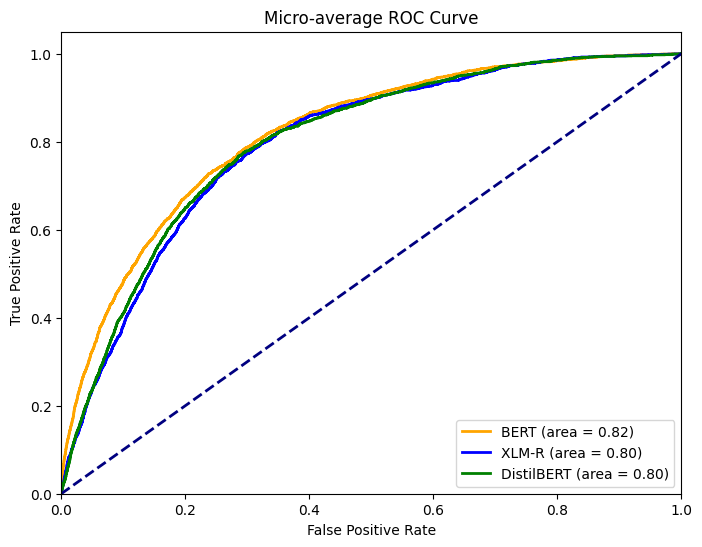

In [ ]:
from sklearn.metrics import roc_curve, auc

# Convert labels to one-hot encoded format for BERT
one_hot_labels_bert = np.zeros((len(test_labels_bert), len(labels_dict)))
for i, label in enumerate(test_labels_bert):
    one_hot_labels_bert[i, label] = 1

# Compute probabilities for each class for BERT
probabilities_bert = np.exp(preds_bert) / np.exp(preds_bert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for BERT
fpr_bert = dict()
tpr_bert = dict()
roc_auc_bert = dict()
for i in range(len(labels_dict)):
    fpr_bert[i], tpr_bert[i], _ = roc_curve(one_hot_labels_bert[:, i], probabilities_bert[:, i])
    roc_auc_bert[i] = auc(fpr_bert[i], tpr_bert[i])

# Compute micro-average ROC curve and AUC score for BERT
fpr_bert["micro"], tpr_bert["micro"], _ = roc_curve(one_hot_labels_bert.ravel(), probabilities_bert.ravel())
roc_auc_bert["micro"] = auc(fpr_bert["micro"], tpr_bert["micro"])

# Convert labels to one-hot encoded format for XLM-R
one_hot_labels_xlmr = np.zeros((len(test_labels_xlmr), len(labels_dict)))
for i, label in enumerate(test_labels_xlmr):
    one_hot_labels_xlmr[i, label] = 1

# Compute probabilities for each class for XLM-R
probabilities_xlmr = np.exp(preds_xlmr) / np.exp(preds_xlmr).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for XLM-R
fpr_xlmr = dict()
tpr_xlmr = dict()
roc_auc_xlmr = dict()
for i in range(len(labels_dict)):
    fpr_xlmr[i], tpr_xlmr[i], _ = roc_curve(one_hot_labels_xlmr[:, i], probabilities_xlmr[:, i])
    roc_auc_xlmr[i] = auc(fpr_xlmr[i], tpr_xlmr[i])

# Compute micro-average ROC curve and AUC score for XLM-R
fpr_xlmr["micro"], tpr_xlmr["micro"], _ = roc_curve(one_hot_labels_xlmr.ravel(), probabilities_xlmr.ravel())
roc_auc_xlmr["micro"] = auc(fpr_xlmr["micro"], tpr_xlmr["micro"])

# Convert labels to one-hot encoded format for DistilBERT
one_hot_labels_distilbert = np.zeros((len(test_labels_distilbert), len(labels_dict)))
for i, label in enumerate(test_labels_distilbert):
    one_hot_labels_distilbert[i, label] = 1

# Compute probabilities for each class for DistilBERT
probabilities_distilbert = np.exp(preds_distilbert) / np.exp(preds_distilbert).sum(axis=1, keepdims=True)

# Compute ROC curve and AUC score for each class for DistilBERT
fpr_distilbert = dict()
tpr_distilbert = dict()
roc_auc_distilbert = dict()
for i in range(len(labels_dict)):
    fpr_distilbert[i], tpr_distilbert[i], _ = roc_curve(one_hot_labels_distilbert[:, i], probabilities_distilbert[:, i])
    roc_auc_distilbert[i] = auc(fpr_distilbert[i], tpr_distilbert[i])

# Compute micro-average ROC curve and AUC score for DistilBERT
fpr_distilbert["micro"], tpr_distilbert["micro"], _ = roc_curve(one_hot_labels_distilbert.ravel(), probabilities_distilbert.ravel())
roc_auc_distilbert["micro"] = auc(fpr_distilbert["micro"], tpr_distilbert["micro"])

# Plot micro-average ROC curve for all models
plt.figure(figsize=(8, 6))
plt.plot(fpr_bert["micro"], tpr_bert["micro"], color='orange', lw=2, label=f'mBERT (area = {roc_auc_bert["micro"]:.2f})')
plt.plot(fpr_xlmr["micro"], tpr_xlmr["micro"], color='blue', lw=2, label=f'XLM-R (area = {roc_auc_xlmr["micro"]:.2f})')
plt.plot(fpr_distilbert["micro"], tpr_distilbert["micro"], color='green', lw=2, label=f'mDistilBERT (area = {roc_auc_distilbert["micro"]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-average ROC Curve')
plt.legend(loc="lower right")
plt.show()


# Classification Report

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Convert predicted labels to the original label format
pred_labels_bert = np.argmax(probabilities_bert, axis=1)
pred_labels_xlmr = np.argmax(probabilities_xlmr, axis=1)
pred_labels_distilbert = np.argmax(probabilities_distilbert, axis=1)

# Compute classification report, accuracy, precision, recall, and F1 score for BERT
class_report_bert = classification_report(test_labels_bert, pred_labels_bert)
accuracy_bert = accuracy_score(test_labels_bert, pred_labels_bert)
precision_bert = precision_score(test_labels_bert, pred_labels_bert, average='weighted')
recall_bert = recall_score(test_labels_bert, pred_labels_bert, average='weighted')
f1_bert = f1_score(test_labels_bert, pred_labels_bert, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for XLM-R
class_report_xlmr = classification_report(test_labels_xlmr, pred_labels_xlmr)
accuracy_xlmr = accuracy_score(test_labels_xlmr, pred_labels_xlmr)
precision_xlmr = precision_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
recall_xlmr = recall_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')
f1_xlmr = f1_score(test_labels_xlmr, pred_labels_xlmr, average='weighted')

# Compute classification report, accuracy, precision, recall, and F1 score for DistilBERT
class_report_distilbert = classification_report(test_labels_distilbert, pred_labels_distilbert)
accuracy_distilbert = accuracy_score(test_labels_distilbert, pred_labels_distilbert)
precision_distilbert = precision_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
recall_distilbert = recall_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')
f1_distilbert = f1_score(test_labels_distilbert, pred_labels_distilbert, average='weighted')

# Print classification reports
print("Classification Report for BERT:")
print(class_report_bert)
print(f"Accuracy for BERT: {accuracy_bert}")
print(f"Precision for BERT: {precision_bert}")
print(f"Recall for BERT: {recall_bert}")
print(f"F1 Score for BERT: {f1_bert}")
print()

print("Classification Report for XLM-R:")
print(class_report_xlmr)
print(f"Accuracy for XLM-R: {accuracy_xlmr}")
print(f"Precision for XLM-R: {precision_xlmr}")
print(f"Recall for XLM-R: {recall_xlmr}")
print(f"F1 Score for XLM-R: {f1_xlmr}")
print()

print("Classification Report for DistilBERT:")
print(class_report_distilbert)
print(f"Accuracy for DistilBERT: {accuracy_distilbert}")
print(f"Precision for DistilBERT: {precision_distilbert}")
print(f"Recall for DistilBERT: {recall_distilbert}")
print(f"F1 Score for DistilBERT: {f1_distilbert}")


Classification Report for BERT:
              precision    recall  f1-score   support

           0       0.34      0.20      0.25       403
           1       0.27      0.24      0.25       186
           2       0.31      0.43      0.36       374
           3       0.32      0.17      0.22       299
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        53
           6       0.30      0.67      0.41       511
           7       0.28      0.27      0.27       180
           8       0.00      0.00      0.00        64
           9       0.00      0.00      0.00        95
          10       0.00      0.00      0.00        51
          11       0.00      0.00      0.00        50
          12       0.00      0.00      0.00        31
          13       0.00      0.00      0.00        14
          14       0.00      0.00      0.00        11
          15       0.00      0.00      0.00         9

    accuracy                           0.30     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix for BERT
conf_matrix_bert = confusion_matrix(test_labels_bert, pred_labels_bert)

# Compute confusion matrix for XLM-R
conf_matrix_xlmr = confusion_matrix(test_labels_xlmr, pred_labels_xlmr)

# Compute confusion matrix for DistilBERT
conf_matrix_distilbert = confusion_matrix(test_labels_distilbert, pred_labels_distilbert)

# Define label names based on labels dictionary
label_names = sorted(labels_dict, key=labels_dict.get)


<Figure size 800x600 with 0 Axes>

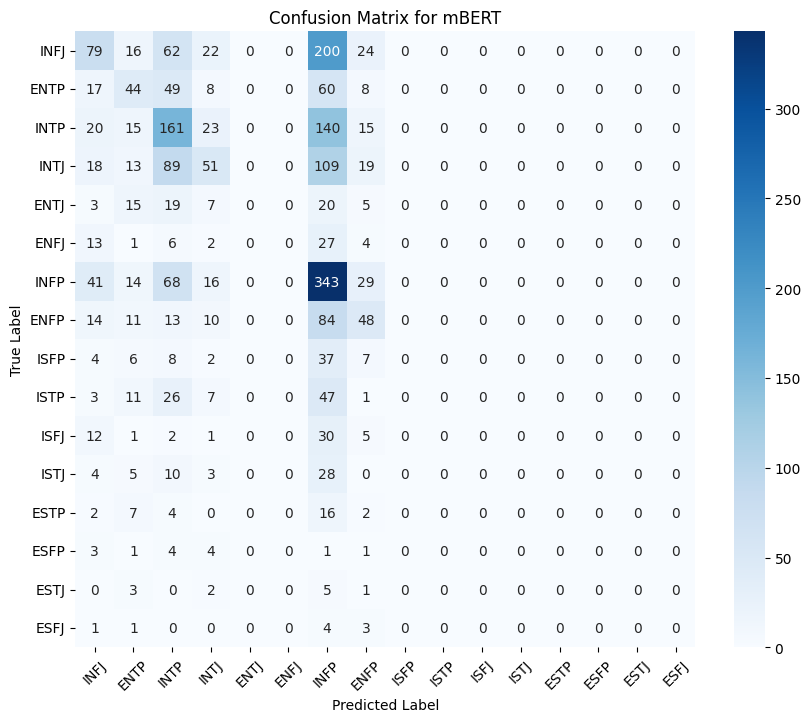

<Figure size 800x600 with 0 Axes>

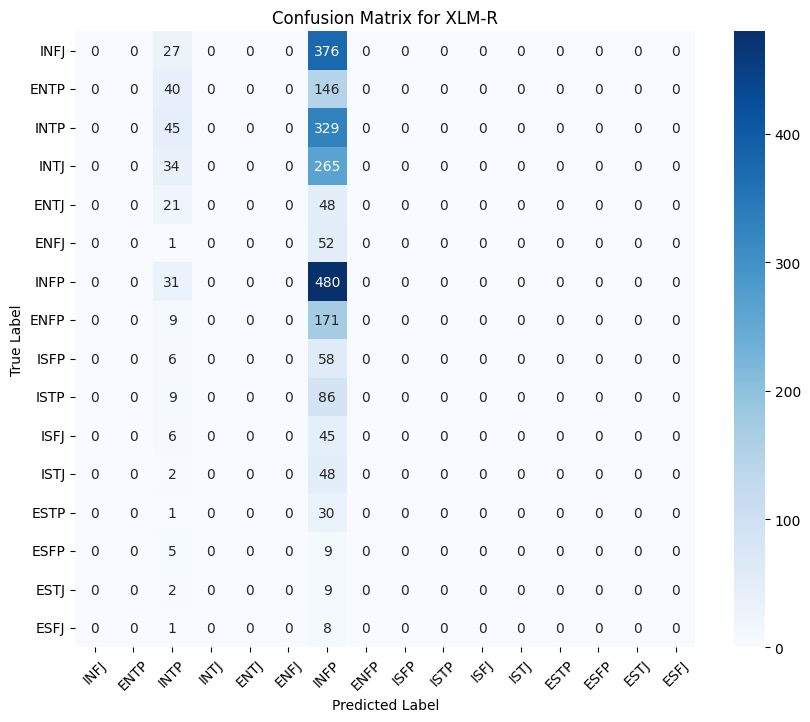

<Figure size 800x600 with 0 Axes>

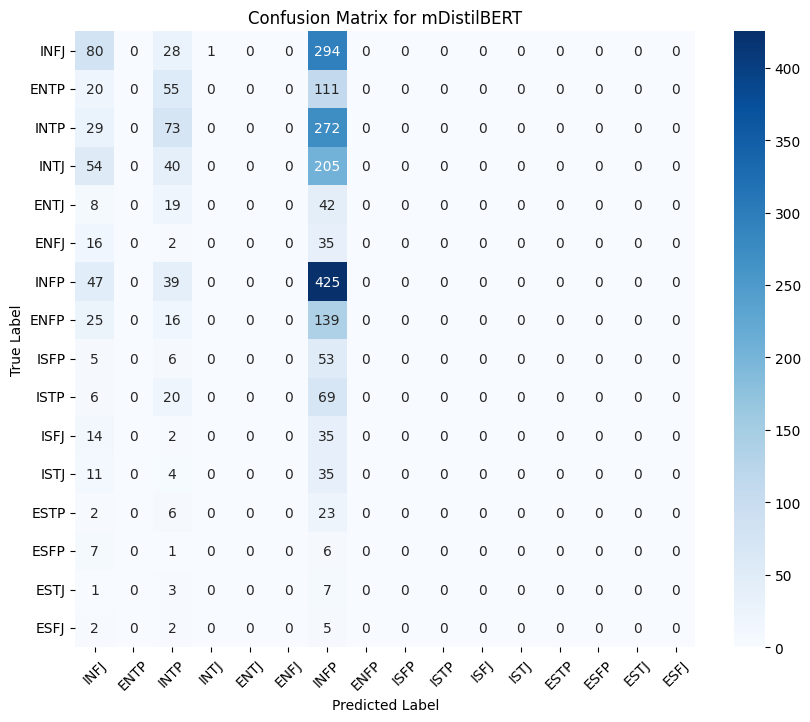

In [ ]:
import seaborn as sns

def plot_confusion_matrix(conf_matrix, label_names, title):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
    plt.title(title)  # Set the title here
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()

# Plot confusion matrix for BERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_bert, label_names, 'Confusion Matrix for mBERT')

# Plot confusion matrix for XLM-R
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_xlmr, label_names, 'Confusion Matrix for XLM-R')

# Plot confusion matrix for DistilBERT
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix_distilbert, label_names, 'Confusion Matrix for mDistilBERT')

# Save the Best Performing Model

In [ ]:
import pickle

# Define the path where you want to save the model
model_save_path = '/content/gdrive/MyDrive/models/final_hn_bert_model.pkl'

# Save the model using pickle
with open(model_save_path, 'wb') as f:
    pickle.dump(bert_model, f)


# Cyber Bullying


In [ ]:
cb = pd.read_csv('/content/gdrive/MyDrive/Hindi_cyber_utf8.csv')
cb

,tweet_text,cyberbullying_type,Unnamed: 2
0,"In other words #katandandre, your food was cra...",not_cyberbullying,"दूसरे शब्दों में #कटांडांद्रे, आपका भोजन स्वाद..."
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,#ऑस्ट्रेलियाई टीवी इतना सफ़ेद क्यों है? #MKR #...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,@XochitlSuckkks एक उत्तम दर्जे की वेश्या? या अ...
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,"@Jason_Gio हुह। :P सचेत करने के लिए धन्यवाद, ल..."
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,@RudhoeEnglish यह एक ISIS अकाउंट है जो कुर्दिश...
...,...,...,...
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,मैं भगवान की कसम खाता हूँ। यह गूंगी हब्शी कुति...
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,"हाँ, बकवास करो RT @ therealexel: यदि तुम एक हब..."
47691,Bro. U gotta chill RT @CHILLShrammy: Dog FUCK ...,ethnicity,भाई। आपको शांत रहना होगा RT @CHILLShrammy: कुत...
47692,NaN,NaN,NaN


In [ ]:
# Drop a column
cb.drop(columns=['tweet_text'], inplace=True)
cb.rename(columns={'Unnamed: 2': 'tweet_text'}, inplace=True)
cb

,cyberbullying_type,tweet_text
0,not_cyberbullying,"दूसरे शब्दों में #कटांडांद्रे, आपका भोजन स्वाद..."
1,not_cyberbullying,#ऑस्ट्रेलियाई टीवी इतना सफ़ेद क्यों है? #MKR #...
2,not_cyberbullying,@XochitlSuckkks एक उत्तम दर्जे की वेश्या? या अ...
3,not_cyberbullying,"@Jason_Gio हुह। :P सचेत करने के लिए धन्यवाद, ल..."
4,not_cyberbullying,@RudhoeEnglish यह एक ISIS अकाउंट है जो कुर्दिश...
...,...,...
47689,ethnicity,मैं भगवान की कसम खाता हूँ। यह गूंगी हब्शी कुति...
47690,ethnicity,"हाँ, बकवास करो RT @ therealexel: यदि तुम एक हब..."
47691,ethnicity,भाई। आपको शांत रहना होगा RT @CHILLShrammy: कुत...
47692,NaN,NaN


<Axes: xlabel='cyberbullying_type'>

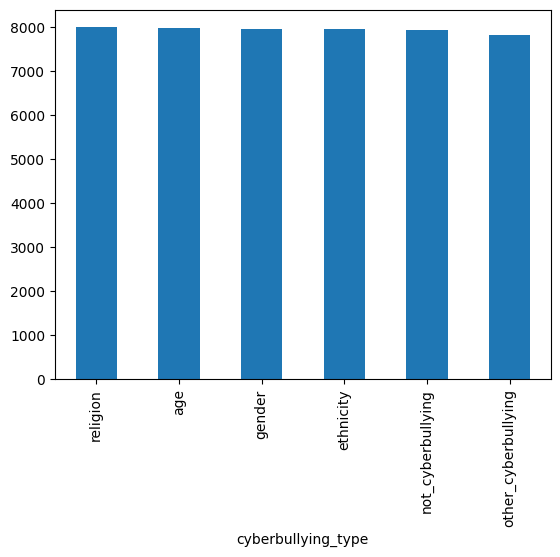

In [ ]:
cb["cyberbullying_type"].value_counts().plot(kind = "bar")

In [ ]:
# Truncate cyberbullying types to 30 characters
cb['cyberbullying_type'] = cb['cyberbullying_type'].str[:30]

In [ ]:
# Create a dictionary to store DataFrames categorized by the first 10 characters
dfs = {}

In [ ]:
# Iterate over unique categories and store filtered DataFrames
for cyberbullying_type in cb['cyberbullying_type'].unique():
    category_cb = cb[cb['cyberbullying_type'] == cyberbullying_type].drop(columns=['cyberbullying_type'])
    dfs[cyberbullying_type] = category_cb

In [ ]:
# Print the segregated DataFrames
for key, value in dfs.items():
    print(f"\nDataFrame for category '{key}':")
    # print(value)


DataFrame for category 'not_cyberbullying':

DataFrame for category 'gender':

DataFrame for category 'religion':

DataFrame for category 'other_cyberbullying':

DataFrame for category 'age':

DataFrame for category 'ethnicity':

DataFrame for category 'nan':


In [ ]:
# Store the segregated DataFrames in a dictionary
segregated_cbs = {
    'not_cyberbul': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'gender': cb[cb['cyberbullying_type'] == 'gender'],
    'religion': cb[cb['cyberbullying_type'] == 'religion'],
    'other_cyberb': cb[cb['cyberbullying_type'] == 'not_cyberbul'],
    'age': cb[cb['cyberbullying_type'] == 'age'],
    'ethnicity': cb[cb['cyberbullying_type'] == 'ethnicity']
}

In [ ]:
# Access the segregated DataFrames using their respective category names
not_cyberbul_cb = segregated_cbs['not_cyberbul']
gender_cb = segregated_cbs['gender']
religion_cb = segregated_cbs['religion']
other_cyberb_cb = segregated_cbs['other_cyberb']
age_cb = segregated_cbs['age']
ethnicity_cb = segregated_cbs['ethnicity']

In [ ]:
# Example: Accessing the 'not_cyberbul' DataFrame
print("Not Cyberbullying DataFrame:")
print(not_cyberbul_cb)

Not Cyberbullying DataFrame:
Empty DataFrame
Columns: [cyberbullying_type, tweet_text]
Index: []


In [ ]:
# Initialize Porter Stemmer
ps = PorterStemmer()

# Load the pre-trained BERT model
with open('/content/gdrive/MyDrive/models/final_hn_bert_model.pkl', 'rb') as f:
    bert_model = pickle.load(f)

In [ ]:
# Define function for tweet preprocessing
def preprocess_tweets(tweets):
    corpus = []
    for tweet in tweets:
        # Remove non-alphabetic characters and convert to lowercase
        tweet_text = re.sub("[^a-zA-Z]", " ", tweet)
        tweet_text = tweet_text.lower()

        # Tokenize the tweet
        tweet_text = tweet_text.split()

        # Remove stopwords and apply stemming
        # tweet_text = [ps.stem(word) for word in tweet_text if word not in stopwords.words("bengali")]

        # Join the processed words back into a single string
        tweet_text = " ".join(tweet_text)

        # Append the processed tweet to the corpus
        corpus.append(tweet_text)
    return corpus

# Define function for BERT prediction
def predict_labels(tokenized_texts):
    predicted_labels = []
    for i in tqdm(range(0, len(tokenized_texts), batch_size), desc="Predicting"):
        input_batch = torch.tensor(tokenized_texts[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = bert_model(input_batch)
            logits = outputs.logits

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class index for each sample in the batch
        batch_predicted_class_indices = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Convert the class indices back to their original labels
        batch_predicted_labels = [reverse_class_labels.get(idx, "Unknown") for idx in batch_predicted_class_indices]

        predicted_labels.extend(batch_predicted_labels)
    return predicted_labels

# Define function to process and predict labels for a given category DataFrame
def process_and_predict(df, category_name, reverse_class_labels):
    # Preprocess tweets
    df["tweet_text"] = df["tweet_text"].fillna("")
    corpus = preprocess_tweets(df["tweet_text"])

    # Tokenize the cleaned texts
    tokenized_texts = [tokenizer.encode(text, add_special_tokens=True) for text in corpus]

    # Pad sequences to ensure uniform length
    max_len = max(len(tokens) for tokens in tokenized_texts)
    padded_texts = [tokens + [0] * (max_len - len(tokens)) for tokens in tokenized_texts]

    # Predict labels
    predicted_labels = predict_labels(padded_texts, reverse_class_labels)

    # Create a new DataFrame to store the original data along with the predicted labels
    predicted_df = df.copy()
    predicted_df['predicted_labels'] = predicted_labels[:len(df)]

    # Print the unique predicted labels
    unique_labels = predicted_df['predicted_labels'].unique()
    print(f"Unique labels for '{category_name}': {unique_labels}")

    # Count the occurrences of each label
    label_counts = Counter(predicted_labels)
    for label, count in label_counts.items():
        print(f"{label}: {count} samples")

    return predicted_df

# Define function for BERT prediction
def predict_labels(tokenized_texts, reverse_class_labels):
    predicted_labels = []
    for i in tqdm(range(0, len(tokenized_texts), batch_size), desc="Predicting"):
        input_batch = torch.tensor(tokenized_texts[i:i+batch_size]).to(device)
        with torch.no_grad():
            outputs = bert_model(input_batch)
            logits = outputs.logits

        # Convert logits to probabilities
        probabilities = torch.softmax(logits, dim=1)

        # Get the predicted class index for each sample in the batch
        batch_predicted_class_indices = torch.argmax(probabilities, dim=1).cpu().numpy()

        # Convert the class indices back to their original labels
        batch_predicted_labels = [reverse_class_labels.get(idx, "Unknown") for idx in batch_predicted_class_indices]

        predicted_labels.extend(batch_predicted_labels)
    return predicted_labels

# Define categories and respective DataFrames
categories = {
    'age': age_cb,
    'religion': religion_cb,
    'gender': gender_cb,
    'ethnicity': ethnicity_cb,
    # Add more categories as needed
}

class_labels = {
        'INFJ': 0, 'ENTP': 1, 'INTP': 2, 'INTJ': 3, 'ENTJ': 4,
        'ENFJ': 5, 'INFP': 6, 'ENFP': 7, 'ISFP': 8, 'ISTP': 9,
        'ISFJ': 10, 'ISTJ': 11, 'ESTP': 12, 'ESFP': 13,
        'ESTJ': 14, 'ESFJ': 15
    }

# Reverse the class_labels dictionary to map indices to labels
reverse_class_labels = {v: k for k, v in class_labels.items()}

# Create dictionaries to store predicted DataFrames for each category
predicted_dfs = {}

# Iterate over categories, process and predict labels
for category_name, df in categories.items():
    print(f"\nProcessing category '{category_name}':")
    predicted_df = process_and_predict(df, category_name, reverse_class_labels)
    # Store the predicted DataFrame for the category
    predicted_dfs[category_name] = predicted_df
    print(f"Predicted DataFrame for '{category_name}':\n{predicted_df.head()}")

# Print keys in the predicted_dfs dictionary
print("\nKeys in predicted_dfs dictionary:", predicted_dfs.keys())



Processing category 'age':


<ipython-input-37-f1edf57ef8c3>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")
Predicting: 100%|██████████| 250/250 [00:52<00:00,  4.74it/s]
<ipython-input-37-f1edf57ef8c3>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'age': ['INFP' 'INFJ']
INFP: 7991 samples
INFJ: 1 samples
Predicted DataFrame for 'age':
      cyberbullying_type                                         tweet_text  \
31739                age  यहाँ घर पर। पड़ोसी मुझे और मेरे परिवार को चिढ़...   
31740                age  स्कूल में धमकाया जाना: उच्च उपलब्धि हासिल करने...   
31741                age  मेरी कक्षा में 6वीं कक्षा में एक लड़की थी जो थ...   
31742                age  वह संभवतः किसी उपनगर का एक श्वेत समलैंगिक बच्च...   
31743                age  आपको सहारा लेने के लिए प्रेरित किया जाता है। ध...   

      predicted_labels  
31739             INFP  
31740             INFP  
31741             INFP  
31742             INFP  
31743             INFP  

Processing category 'religion':


Predicting: 100%|██████████| 250/250 [00:55<00:00,  4.49it/s]
<ipython-input-37-f1edf57ef8c3>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'religion': ['INFP']
INFP: 7998 samples
Predicted DataFrame for 'religion':
      cyberbullying_type                                         tweet_text  \
15918           religion  सुदीप, क्या उसने उसे आमंत्रित किया था? कोई अधि...   
15919           religion  @discerningmumin इस्लाम कभी भी उत्पीड़न का प्र...   
15920           religion  लड़के, चर्चों को बंद रखने की इच्छा रखने वाले प...   
15921           religion  @ShashiTharoor @INCIndia कश्मीर में मुस्लिम आत...   
15922           religion  श्वेत वर्चस्ववादी? आप कितनों को जानते हैं? सभी...   

      predicted_labels  
15918             INFP  
15919             INFP  
15920             INFP  
15921             INFP  
15922             INFP  

Processing category 'gender':


Predicting: 100%|██████████| 250/250 [00:43<00:00,  5.72it/s]
<ipython-input-37-f1edf57ef8c3>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tweet_text"] = df["tweet_text"].fillna("")


Unique labels for 'gender': ['INFP']
INFP: 7973 samples
Predicted DataFrame for 'gender':
     cyberbullying_type                                         tweet_text  \
7945             gender  बलात्कार वास्तविक है..ज़्वासियाना नेमा नशे में...   
7946             gender  आपने कभी किसी सेलिब्रिटी को ओबामा के लिए ऐसा क...   
7947             gender  @ManhattaKnight मेरा मतलब है कि वह समलैंगिक है...   
7948             gender  RT @Raul_Novoa16: @AliciaBernardez @Alex_Aim @...   
7949             gender  बलात्कार तो बलात्कार है. और तथ्य यह है कि मैंन...   

     predicted_labels  
7945             INFP  
7946             INFP  
7947             INFP  
7948             INFP  
7949             INFP  

Processing category 'ethnicity':


Predicting: 100%|██████████| 249/249 [00:51<00:00,  4.84it/s]

Unique labels for 'ethnicity': ['INFP' 'INFJ']
INFP: 7960 samples
INFJ: 1 samples
Predicted DataFrame for 'ethnicity':
      cyberbullying_type                                         tweet_text  \
39731          ethnicity  अरे मूर्ख सेलेब्स फेसबुक पर पब्लिसिटी के लिए ल...   
39732          ethnicity  भाड़ में जाओ कुतिया RT @tayyoung_: भाड़ में जा...   
39733          ethnicity  @JoeBiden नहीं जो, तुम नस्लवादी हो। उनके पास आ...   
39734          ethnicity  जब आपका ट्रक बेकार दिखता है तो उसे और भी बदतर ...   
39735          ethnicity            आज कैफ़े में वह निगर खाना बहुत घृणित था   

      predicted_labels  
39731             INFP  
39732             INFP  
39733             INFP  
39734             INFP  
39735             INFP  

Keys in predicted_dfs dictionary: dict_keys(['age', 'religion', 'gender', 'ethnicity'])


In [ ]:
# Access the predicted DataFrame for a specific category
predicted_df_age = predicted_dfs.get('age')
predicted_df_religion = predicted_dfs.get('religion')

In [ ]:
predicted_df_age

,cyberbullying_type,tweet_text,predicted_labels
31739,age,यहाँ घर पर। पड़ोसी मुझे और मेरे परिवार को चिढ़...,INFP
31740,age,स्कूल में धमकाया जाना: उच्च उपलब्धि हासिल करने...,INFP
31741,age,मेरी कक्षा में 6वीं कक्षा में एक लड़की थी जो थ...,INFP
31742,age,वह संभवतः किसी उपनगर का एक श्वेत समलैंगिक बच्च...,INFP
31743,age,आपको सहारा लेने के लिए प्रेरित किया जाता है। ध...,INFP
...,...,...,...
39726,age,इस लड़की ने वास्तव में यह कहने की कोशिश की कि ...,INFP
39727,age,स्कूल में एक बदमाश जो तीसरी कक्षा से मेरे साथ ...,INFP
39728,age,मुझे याद है कि मैंने छठी कक्षा में 'बो डाउन' न...,INFP
39729,age,मैं प्रोम क्वीन नहीं थी। मैं धमकाने वाली लड़की...,INFP
